In [ ]:
# We need to pip install category encoders and pdp box
!pip install category_encoders;
!pip install pdpbox;
!pip install shap;

Features Legend

* enrollee_id : Unique ID for candidate

* city: City code

* city_ development _index : Developement index of the city (scaled)

* gender: Gender of candidate

* relevent_experience: Relevant experience of candidate

* enrolled_university: Type of University course enrolled if any

* education_level: Education level of candidate

* major_discipline :Education major discipline of candidate

* experience: Candidate total experience in years

* company_size: No of employees in current employer's company

* company_type : Type of current employer

* lastnewjob: Difference in years between previous job and current job

* training_hours: training hours completed

* target: 0 – Not looking for job change, 1 – Looking for a job change



In [2]:
# Let's import some of those libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_plot, pdp_isolate
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

In [3]:
# Let's see what we're starting with here and read in the data. 
# # I found out enrollee_id should be the index, let's amend:
train = pd.read_csv('aug_train.csv', index_col='enrollee_id')
test = pd.read_csv('aug_test.csv', index_col='enrollee_id')
train

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0


In [4]:
print(test.shape)
print(train['target'].value_counts())

(2129, 12)
0.0    14381
1.0     4777
Name: target, dtype: int64


In [5]:
# So just a cursory glance reveals we have some NaNs. It looks like we have a column
# that should serve as our index, which means we can do a random split instead of 
# worrying about a time series. It looks like we have only 2 columns with number
# values, which will probably be dropped due to high cardinality. 

In [6]:
# Since the classes for our target are skewed we are going to do some undersampling
# of our majority class
data_true = train[train['target'] == 1]
data_false = train[train['target'] == 0]

data_true_train, data_true_test = train_test_split(data_true, test_size=0.2, random_state=42)
data_false_train, data_false_test = train_test_split(data_false, test_size=0.2, random_state=42)

data_false_train = data_false_train.sample(5000, replace=False)
X_train = data_true_train.append(data_false_train, ignore_index=True)
X_test = data_true_test.append(data_false_test, ignore_index=True)

In [7]:
print(X_train['target'].value_counts())
print(X_test.shape)
print(X_train.shape)

0.0    5000
1.0    3821
Name: target, dtype: int64
(3833, 13)
(8821, 13)


In [8]:
# I'm going to split my data real quick 
y_train = X_train['target']
y_test = X_test['target']
X_train.drop(columns='target', inplace=True)
X_test.drop(columns='target', inplace=True)

In [9]:
# We have mostly object data types so we should be good for the most part
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158 entries, 8949 to 23834
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.0+ MB


In [10]:
train['company_size'].value_counts()

50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [11]:
# We also have more NaNs than I want so we'll just impute those later

train.isna().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [12]:
# Ok since we have our data read in and we've taken a peek at it, it looks like 
# there's some cleaning to do in our wrangle function mainly for high cardinality, but it's
# not too bad otherwise. I'll probably have to come back and play with the threshold
# but we'll see. 

def wrangle (df):
  
  # We're gonna drop the high cardinality columns real quick
  cols_to_drop = [col for col in df if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Change a / to a - symbol in our company size column
  df['company_size'] = df['company_size'].str.replace('/', '-').astype('category')
  
  # My permutation importances are leading me to believe I can drop the 
  # enrolled_university feature
  df.drop(columns = 'enrolled_university', inplace=True)

  return df


X_train = wrangle(X_train)
X_test = wrangle(X_test)

In [13]:
# Let's set our baseline

baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy is', baseline_acc)

Baseline accuracy is 0.5668291576918717


In [14]:
# Time to build some models!
# Logistic Regression:
model_lr = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         LogisticRegression(random_state=42))
model_lr.fit(X_train, y_train);

In [15]:
# Random Forest:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(), 
                         RandomForestClassifier(random_state=42))
model_rf.fit(X_train, y_train); 

In [16]:
# XGBoost:
model_xgb = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(),
                          XGBClassifier(random_state=42))
model_xgb.fit(X_train, y_train);

In [17]:
# Let's see what our scores are
model = [model_lr, model_rf, model_xgb];

def check_metrics (model):
  print(model);
  print('Training Accuracy', accuracy_score(y_train, model.predict(X_train)));
  print('Test Accuracy', accuracy_score(y_test, model.predict(X_test)));

for m in (model):
  check_metrics(m);

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'relevent_experience',
                                      'education_level', 'major_discipline',
                                      'experience', 'company_size',
                                      'company_type', 'last_new_job'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN       3
Other     4
dtype: int...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_w

In [18]:
# I'm going to "quickly" tune my hyperparameters

# # Logistic Regression Tuning:

# model_lht = make_pipeline(OrdinalEncoder(), 
#                          SimpleImputer(),
#                          LogisticRegression(random_state=42))

# param_grid = {
#     'simpleimputer__strategy': ['median', 'mean'], 
#     'logisticregression__max_iter': range(100, 300, 25),
# }

# model_lrrs = RandomizedSearchCV(
#     model_lht, 
#     param_distributions = param_grid, 
#     n_iter = 20,
#     cv=5,
#     n_jobs=-1
# )

# model_lrrs.fit(X_train, y_train);

# # XGBoost Tuning:

# model_ht = make_pipeline(OrdinalEncoder(), 
#                          SimpleImputer(),
#                          XGBClassifier(random_state=42))

# param_grid = {
#     'simpleimputer__strategy': ['median', 'mean'], 
#     'xgbclassifier__max_depth': range(1, 10, 1),
#     'xgbclassifier__n_estimators': range(25, 150, 25),
#     'xgbclassifier__learning_rate': [0.005, 0.05, 0.1, 0.2, 0.6, 0.99]
# }

# model_xgbrs = RandomizedSearchCV(
#     model_ht, 
#     param_distributions = param_grid, 
#     n_iter = 20,
#     cv=5,
#     n_jobs=-1
# )

# model_xgbrs.fit(X_train, y_train);

In [19]:
# Pull out the best parameters to tune our new models. 
# I think it's funny when the default settings are the best parameters.
# print(model_lrrs.best_params_)

In [20]:
# print(model_xgbrs.best_params_)

In [21]:
# Let's tune the Logistic Regression model
tuned_model_lr = make_pipeline(OrdinalEncoder(),
                               SimpleImputer(strategy='median'),
                               LogisticRegression(max_iter=100))
tuned_model_lr.fit(X_train, y_train);

In [22]:
# Let's tune the XGBoost model and re-run our metrics
tuned_model_xgb = make_pipeline(OrdinalEncoder(),
                                SimpleImputer(strategy='mean'), 
                                XGBClassifier(max_depth=6,
                                              n_estimators=100,
                                              learning_rate=0.05,
                                              random_state=42))
tuned_model_xgb.fit(X_train, y_train);

In [23]:
print('Tuned LR training accuracy', tuned_model_lr.score(X_train, y_train))
print('Tuned LR testing accuracy', tuned_model_lr.score(X_test, y_test))
print('RF training accuracy', model_rf.score(X_train, y_train))
print('RF testing accuracy', model_rf.score(X_test, y_test))
print('Tuned XGB training accuracy', tuned_model_xgb.score(X_train, y_train))
print('Tuned XGB testing accuracy', tuned_model_xgb.score(X_test, y_test))

Tuned LR training accuracy 0.711370592903299
Tuned LR testing accuracy 0.7427602400208714
RF training accuracy 0.9613422514454143
RF testing accuracy 0.75997912861988
Tuned XGB training accuracy 0.7996825756716925
Tuned XGB testing accuracy 0.7907644142968954


In [24]:
print(classification_report(y_test, model_xgb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      2877
         1.0       0.55      0.72      0.62       956

    accuracy                           0.78      3833
   macro avg       0.72      0.76      0.74      3833
weighted avg       0.81      0.78      0.79      3833



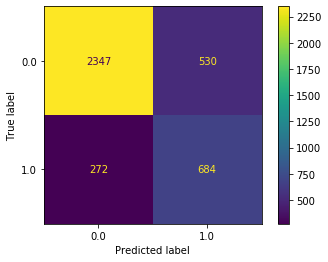

In [25]:
# I'm curious about our true and false positives as this can impact how much money
# we will be able to save by cutting waste.
%matplotlib inline
plot_confusion_matrix(tuned_model_xgb, X_test, y_test, values_format='d')

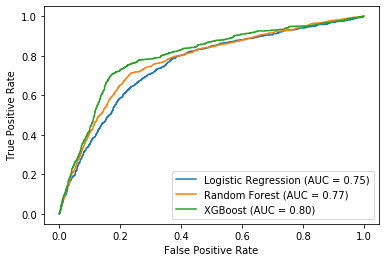

In [26]:
# An ROC to see how well the model is performing
lr = plot_roc_curve(tuned_model_lr, X_test, y_test, name='Logistic Regression')
rf = plot_roc_curve(model_rf, X_test, y_test, name='Random Forest', ax=lr.ax_)
xgb = plot_roc_curve(tuned_model_xgb, X_test, y_test, name='XGBoost', ax=lr.ax_)

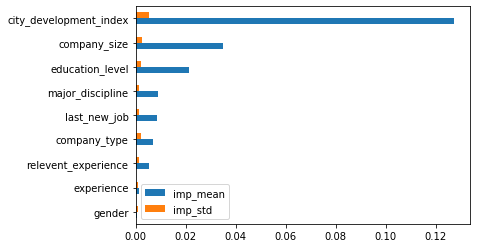

In [27]:
perm_imp = permutation_importance(tuned_model_xgb, X_test, y_test, random_state=42)
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}
permutation_importances = pd.DataFrame(data, index=X_test.columns).sort_values(by='imp_mean').tail(15).plot(kind='barh')

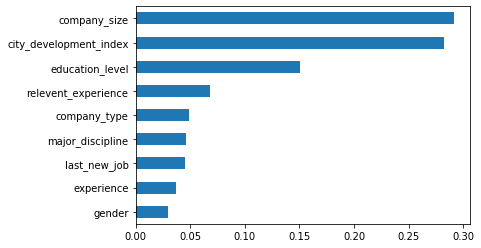

In [28]:
imp = tuned_model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_test.columns
feature_imp = pd.Series(imp, index=feature_names).sort_values(ascending=True).tail(15).plot(kind='barh')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


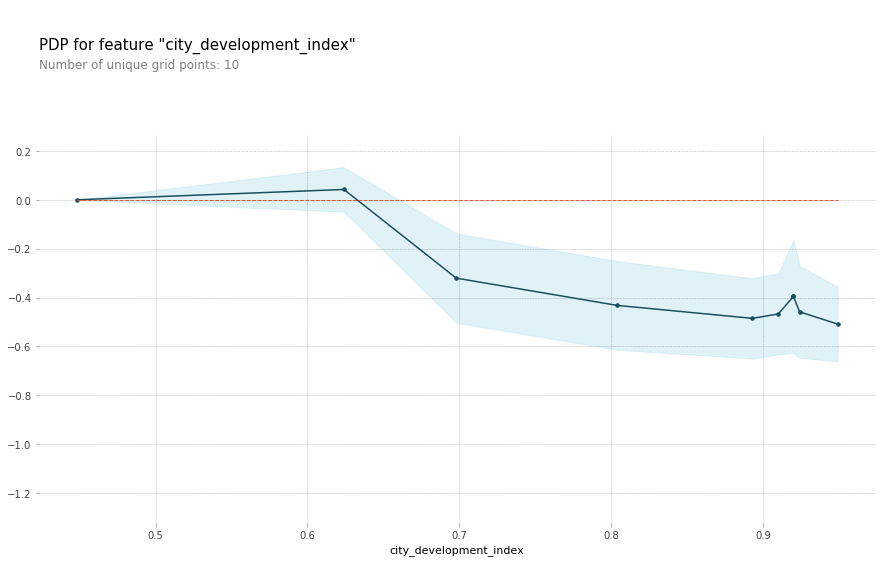

In [29]:
isolate = pdp_isolate(tuned_model_xgb,
                      dataset = X_test,
                      model_features = X_test.columns,
                      feature = 'city_development_index')
pdp_plot(isolate, feature_name = 'city_development_index');

In [30]:
# I have to transform my data so I could feed it through pdp and shapley. This
# made me waste a lot of time lol.
X_test_transformed = tuned_model_xgb.named_steps['ordinalencoder'].transform(X_test)
X_train_transformed = tuned_model_xgb.named_steps['ordinalencoder'].transform(X_train)

In [31]:
# Non-pipeline model for pdp and shap
model_pdp = XGBClassifier(max_depth=6,
                          learning_rate=0.05,
                          n_estimators=75,
                          random_state=42)
model_pdp.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=75, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f29fea643d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f29fea3e610>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


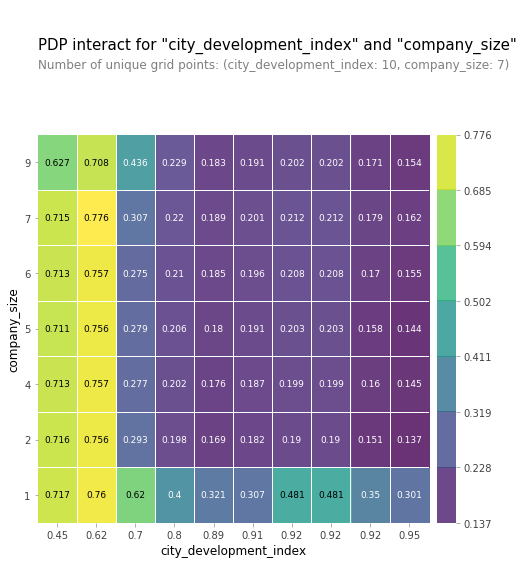

In [32]:
# Let's plot the interaction between city_development_index and company_size
features = ['city_development_index', 'company_size']
interact = pdp_interact(model_pdp,
                        dataset = X_test_transformed,
                        model_features = X_test.columns,
                        features = features)
pdp_interact_plot(interact, plot_type='grid',feature_names=features)

In [33]:
# I want to know the individual contributions of the features so let's do a force
# plot and then waterfall it up. 
samp = X_test_transformed.tail(1)
explainer = shap.TreeExplainer(model_pdp) 
shap_values = explainer.shap_values(samp)
shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values, 
                features=samp)

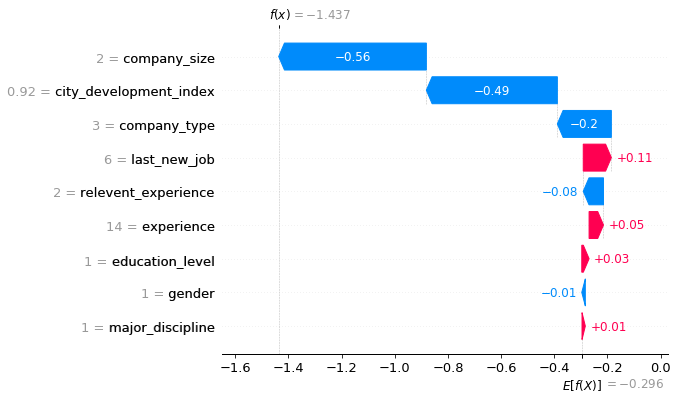

In [34]:
explainer = shap.TreeExplainer(model_pdp) 
shap_values = explainer(X_test_transformed)
shap.plots.waterfall(shap_values[0])